In [4]:
import torch
import matplotlib.pyplot as plt

In [11]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 20),
    torch.nn.Tanh(),
    torch.nn.Linear(20, 1),
)
model.load_state_dict(torch.load('tanh-20.pth'))

<All keys matched successfully>

In [12]:
model

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=1, bias=True)
)

torch.Size([1000, 1]) torch.Size([1000, 1])


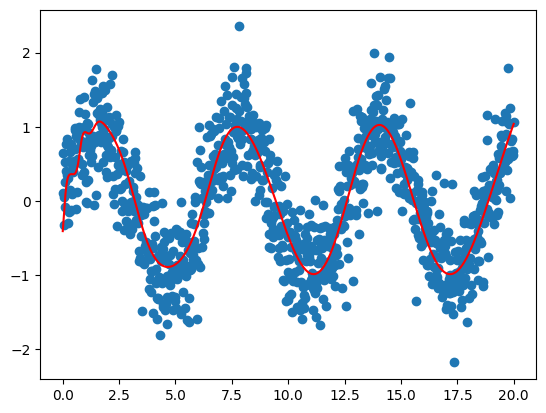

In [13]:
n = 1_000
X = torch.linspace(0, 20, n).reshape(-1, 1)
Y = torch.sin(X) + torch.randn(n, 1) * 0.4 + torch.randn(n, 1) * 0.1
print(Y.shape, X.shape)
plt.scatter(X, Y)
plt.plot(X, model(X).detach(), c='r')

In [14]:
from sklearn.cluster import KMeans

# def k_means_quantization(image_ndarray: np.ndarray, k=2):
# 	H, W, C = image_ndarray.shape
# 	colors, labels = k_means(image_ndarray.reshape(-1, C), k)
# 	quantized_image = assign_colors(labels, colors, k).reshape(H, W, C)
# 	return Image.fromarray(quantized_image.astype(np.uint8))
def k_means(X, k=2):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    return kmeans.cluster_centers_, kmeans.labels_

def quantize(weights, k=2):
    # 1. apply k means clustering to the weights in a linear fashion
    # 2. take the values and put them in the codebook
    centroids, labels = k_means(weights.reshape(-1, 1), k)
    codebook = torch.tensor(centroids, dtype=torch.float32)
    new_weights = torch.tensor(labels, dtype=torch.uint8).reshape(weights.shape)
    return codebook, new_weights

def index(weight_matrix, codebook):
	new_weights = torch.zeros_like(weight_matrix).to(torch.float32)
	for i in range(len(codebook)):
		new_weights[weight_matrix == i] = codebook[i]
	return new_weights

In [19]:
bits = 4
model.load_state_dict(torch.load('tanh-20.pth'))
with torch.no_grad():
	for p in model.parameters():
		if len(p.data) > 2**bits:
			codebook, weights = quantize(p.data, k=int(2**bits))
			p.data = index(weights, codebook)

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


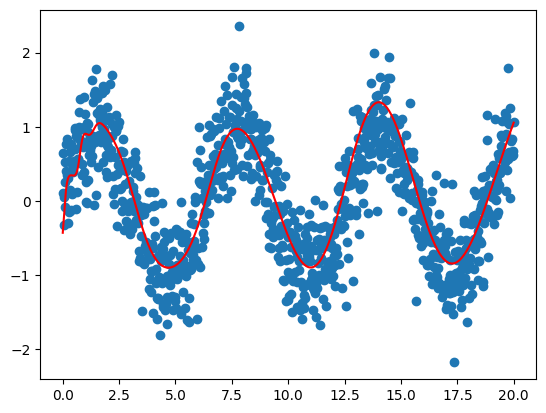

In [20]:
plt.scatter(X, Y)
plt.plot(X, model(X).detach(), c='r')